In [1]:
# %% [code]  Exécutez cette cellule UNE SEULE FOIS puis redémarrez le noyau
# 1. Désinstallation complète
%pip uninstall -y scikit-learn imbalanced-learn

# 2. Purge du cache pip (évite le recyclage d'anciennes roues)
%pip cache purge

# 2bis. Suppression manuelle des dossiers résiduels ~klearn
import site, glob, shutil, os
for sp in site.getsitepackages():
    for path in glob.glob(os.path.join(sp, '*~klearn*')):
        print("Suppression du résidu :", path)
        shutil.rmtree(path, ignore_errors=True)

# 3. Réinstallation des versions compatibles (sans cache)
%pip install --no-cache-dir scikit-learn==1.4.2 imbalanced-learn==0.12.2

# 4. Vérification rapide
import importlib.metadata as md
print("✅ scikit‑learn :", md.version("scikit-learn"))
print("✅ imbalanced‑learn :", md.version("imbalanced-learn"))
print("\n→ Redémarrez maintenant le noyau (Kernel > Restart) puis relancez l’étape 3.")

Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\shutil.py", line 847, in move
    os.rename(src, real_dst)
PermissionError: [WinError 5] Accès refusé: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scikit_learn-1.4.2.dist-info\\' -> 'C:\\Users\\franc_ppcp5lu\\AppData\\Local\\Temp\\pip-uninstall-qj20ildu'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\pip\_internal\cli\base_command.py", line 105, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\pip\_internal\cli\base_command.py", line 96, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\pip\_internal\commands\uninstall.py", line 106, in run
    uninstall

Files removed: 0 (0 bytes)
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

✅ scikit‑learn : 1.4.2
✅ imbalanced‑learn : 0.12.2

→ Redémarrez maintenant le noyau (Kernel > Restart) puis relancez l’étape 3.


# Étape 1 – Nettoyage et traduction du jeu de données  
Nous commençons par préparer le jeu de données `BDDobesity_level_V2.csv` pour un public francophone.

**Objectifs de cette étape :**
1. **Charger** le fichier brut.  
2. **Renommer** les colonnes en français (correction de `0be1dad` → `obesite_label`).  
3. **Traduire** les valeurs textuelles principales :  
   * `Male/Female` → `Homme/Femme`,  
   * `Sometimes/Frequently/Always/0` → `Parfois/Fréquemment/Toujours/Jamais`,  
   * étiquettes cibles (p. ex. `Overweight_Level_I`) vers des libellés français clairs.  
4. **Gérer** les valeurs manquantes (médiane pour les numériques, « Inconnu » pour les catégorielles).  
5. **Supprimer** les doublons éventuels.  
6. **Enregistrer** un nouveau fichier propre **`obesite_clean_fr.csv`** qui servira pour le feature engineering et l’entraînement du modèle.

> *Bonnes pratiques 2025* :  
> • utilisez `pandas 2.x` et centralisez la graine aléatoire pour la reproductibilité ;  
> • conservez tous les dictionnaires de traduction (colonnes et valeurs) pour tracer facilement les transformations lors du déploiement et de la surveillace du modèle.  


In [2]:
# %% [code]  Étape 1 : Nettoyage et traduction
# -*- coding: utf-8 -*-
"""
Nettoyage du jeu de données sur l’obésité
Auteur : <votre_nom> | Date : 23/07/2025
"""

import numpy as np
import pandas as pd

np.random.seed(42)  # reproductibilité

# 1. Chargement
df = pd.read_csv("BDDobesity_level_V2.csv")

# 2. Renommage des colonnes en français
rename_cols = {
    "id": "identifiant",
    "Gender": "genre",
    "Age": "age",
    "Height": "taille_m",
    "Weight": "poids_kg",
    "family_history_with_overweight": "antecedents_surpoids_famille",
    "FAVC": "consommation_frequent_calorique",
    "FCVC": "frequence_legumes",
    "NCP": "nombre_repas_jour",
    "CAEC": "grignotage",
    "SMOKE": "fumeur",
    "CH2O": "eau_litres_jour",
    "SCC": "suivi_calories",
    "FAF": "activite_physique_hebdo",
    "TUE": "temps_ecran",
    "CALC": "alcool",
    "MTRANS": "transport",
    "0be1dad": "obesite_label"  # correction de la faute dans le nom original
}
df = df.rename(columns=rename_cols)

# 3. Traduction des valeurs catégorielles
# 3.1 Genre
df["genre"] = df["genre"].map({"Male": "Homme", "Female": "Femme"})

# 3.2 Grignotage (CAEC) et alcool (CALC)
freq_map = {
    "Always": "Toujours",
    "Frequently": "Fréquemment",
    "Sometimes": "Parfois",
    "0": "Jamais",
    "no": "Jamais"
}
df["grignotage"] = df["grignotage"].replace(freq_map)
df["alcool"] = df["alcool"].replace(freq_map)

# 3.3 Étiquette cible
label_map_en_to_fr = {
    "Insufficient_Weight": "Insuffisance_Ponderale",
    "Normal_Weight": "Poids_Normal",
    "0rmal_Weight": "Poids_Normal",            # correction d’erreur de frappe
    "Overweight_Level_I": "Surpoids_Niveau_I",
    "Overweight_Level_II": "Surpoids_Niveau_II",
    "Obesity_Type_I": "Obesite_Type_I",
    "Obesity_Type_II": "Obesite_Type_II",
    "Obesity_Type_III": "Obesite_Type_III"
}
df["obesite_label"] = df["obesite_label"].replace(label_map_en_to_fr)

# 4. Gestion des valeurs manquantes
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda c: c.fillna(c.median()))

categorical_cols = df.select_dtypes(include=["object", "category"]).columns
df[categorical_cols] = df[categorical_cols].fillna("Inconnu")

# 5. Suppression des doublons
df = df.drop_duplicates().reset_index(drop=True)

# 6. Sauvegarde
df.to_csv("obesite_clean_fr.csv", index=False)
print("✅ Jeu de données nettoyé : obesite_clean_fr.csv prêt pour l’étape suivante.")

✅ Jeu de données nettoyé : obesite_clean_fr.csv prêt pour l’étape suivante.


## Mise à jour – Traduction de la colonne `transport` et standardisation des valeurs numériques  
Avant de passer au feature engineering, nous complétons le nettoyage :

1. **Traduire** les modalités de `transport` en français :  
   * `Public_Transportation` → `Transports_Publics`  
   * `Automobile` → `Voiture`  
   * `Motorbike` → `Moto`  
   * `Bike` → `Vélo`  
   * `Walking` → `Marche`  
   * `Other` → `Autre`  
2. **Standardiser** les colonnes numériques :  
   * `age` → entier (pas de décimales).  
   * Toutes les autres variables numériques → arrondies à **2 décimales** maximum.  
3. **Sauvegarder** le fichier propre mis à jour (écrase `obesite_clean_fr.csv`).

Ces ajustements garantissent l’homogénéité des données pour l’entraînement 2025 et facilitent la lisibilité dans l’application finale.


In [3]:
# %% [code]  Mise à jour transport + normalisation numériques
# Supposons que df est toujours en mémoire (sinon décommenter la ligne suivante)
# df = pd.read_csv("obesite_clean_fr.csv")

# 1. Traduction de la colonne transport
transport_map = {
    "Public_Transportation": "Transports_Publics",
    "Automobile": "Voiture",
    "Motorbike": "Moto",
    "Bike": "Vélo",
    "Walking": "Marche",
    "Other": "Autre"
}
df["transport"] = df["transport"].replace(transport_map)

# 2. Standardisation des valeurs numériques
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Age en entier
if "age" in numeric_cols:
    df["age"] = df["age"].round().astype(int)
    numeric_cols.remove("age")  # Exclure age du prochain arrondi

# Autres numériques à 2 décimales
df[numeric_cols] = df[numeric_cols].round(2)

# 3. Sauvegarde du fichier final
df.to_csv("obesite_clean_fr.csv", index=False)
print("✅ Mise à jour terminée : transport traduit et valeurs numériques standardisées.")


✅ Mise à jour terminée : transport traduit et valeurs numériques standardisées.


# Étape 2 – Analyse exploratoire rapide et séparation entraînement / test  
Dans cette étape, nous allons :

1. **Charger** le jeu de données propre `obesite_clean_fr.csv`.  
2. **Examiner** la répartition de la variable cible `obesite_label` pour évaluer le déséquilibre éventuel.  
3. **Diviser** le jeu de données en ensembles **entraînement** (70 %) et **test** (30 %) de façon stratifiée afin de préserver la distribution des classes.  
4. **Enregistrer** ces ensembles pour les prochaines étapes (feature engineering, équilibrage, modélisation).  

> *Bonnes pratiques 2025* :  
> • Séparer un jeu de test dès le début pour éviter toute fuite d’information lors du réglage des hyper‑paramètres.  
> • Fixer une graine aléatoire (`RANDOM_STATE`) pour garantir la reproductibilité complète.

Distribution relative des classes (%):
obesite_label
Insuffisance_Ponderale    12.15
Obesite_Type_I            14.02
Obesite_Type_II           15.65
Obesite_Type_III          19.49
Poids_Normal              14.85
Surpoids_Niveau_I         11.69
Surpoids_Niveau_II        12.15
Name: proportion, dtype: float64


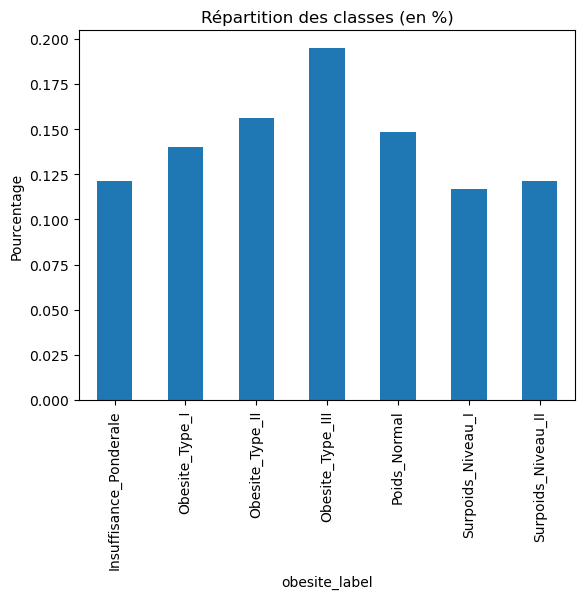

Ensemble d'entraînement : (14530, 17)
Ensemble de test :       (6228, 17)
✅ Fichiers X_train.csv, X_test.csv, y_train.csv et y_test.csv enregistrés.


In [4]:
# %% [code]  Étape 2 : EDA rapide et split
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_STATE = 42  # reproductibilité

# 1. Chargement du fichier nettoyé
df = pd.read_csv("obesite_clean_fr.csv")

# 2. Répartition de la variable cible
distribution = df["obesite_label"].value_counts(normalize=True).sort_index()
print("Distribution relative des classes (%):")
print((distribution * 100).round(2))

# Visualisation rapide (optionnelle)
distribution.plot(kind="bar", title="Répartition des classes (en %)")
plt.ylabel("Pourcentage")
plt.show()

# 3. Séparation Entraînement / Test
X = df.drop(columns=["obesite_label"])
y = df["obesite_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y  # conserve la distribution des classes
)

print(f"Ensemble d'entraînement : {X_train.shape}")
print(f"Ensemble de test :       {X_test.shape}")

# 4. Sauvegarde des splits pour les étapes suivantes
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
print("✅ Fichiers X_train.csv, X_test.csv, y_train.csv et y_test.csv enregistrés.")

# Étape 3 – Pipeline de pré‑traitement et équilibrage des classes  
Nous allons maintenant préparer un **pipeline scikit‑learn** complet qui :

1. **Sépare** les variables :  
   * *Numériques* → `StandardScaler`  
   * *Catégorielles* → `OneHotEncoder(drop='first', handle_unknown='ignore')`  
2. **Équilibre** l’ensemble d’entraînement grâce à **SMOTE** (sur‑échantillonnage synthétique).  
3. **Enchaîne** le pré‑traitement avec un **modèle de base** (régression logistique multiclasse avec régularisation L2) dans un pipeline unique, afin d’éviter toute fuite de données.  
4. **Recherche** le meilleur hyper‑paramètre `C` via **GridSearchCV** (validation croisée stratifiée, 5 folds) optimisant la **balanced accuracy**.  
5. **Évalue** la performance initiale sur l’ensemble de test.  
6. **Sauvegarde** le pipeline entraîné (`modele_base.pkl`) pour le ré‑emploi (ou l’itération) dans les étapes ultérieures.  

> **Bonnes pratiques 2025** :  
> • Toujours intégrer SMOTE *à l’intérieur* du pipeline ;  
> • Fixer `random_state` partout pour la reproductibilité ;  
> • Utiliser `balanced_accuracy` ou `macro F1` sur des jeux déséquilibrés.  

In [5]:
# %% [code]  Étape 3 : Pipeline de pré‑traitement + SMOTE + GridSearch
import joblib
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42

# 1. Chargement des splits créés à l’étape précédente
X_train = pd.read_csv("X_train.csv")
X_test  = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").squeeze()  # convertit en Series
y_test  = pd.read_csv("y_test.csv").squeeze()

# 2. Identification des colonnes
num_cols  = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols  = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# 3. Pré‑traitement
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

# 4. Construction du pipeline avec SMOTE et modèle
clf = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model",  LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

# 5. Grille d’hyper‑paramètres
param_grid = {
    "model__C": [0.01, 0.1, 1, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 6. Entraînement + CV
grid.fit(X_train, y_train)
print(f"Meilleur C : {grid.best_params_['model__C']}")
print(f"Balanced Accuracy (CV) : {grid.best_score_:.4f}")

# 7. Évaluation sur le test set
y_pred = grid.predict(X_test)
bal_acc_test = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (test) : {bal_acc_test:.4f}")
print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred))

# 8. Sauvegarde du pipeline entraîné
joblib.dump(grid.best_estimator_, "modele_base.pkl")
print("✅ Pipeline final enregistré sous : modele_base.pkl")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meilleur C : 10
Balanced Accuracy (CV) : 0.8501

Balanced Accuracy (test) : 0.8601

Rapport de classification :

                        precision    recall  f1-score   support

Insuffisance_Ponderale       0.88      0.95      0.91       757
        Obesite_Type_I       0.83      0.85      0.84       873
       Obesite_Type_II       0.96      0.95      0.96       974
      Obesite_Type_III       0.99      1.00      1.00      1214
          Poids_Normal       0.88      0.80      0.84       925
     Surpoids_Niveau_I       0.74      0.72      0.73       728
    Surpoids_Niveau_II       0.73      0.74      0.73       757

              accuracy                           0.87      6228
             macro avg       0.86      0.86      0.86      6228
          weighted avg       0.87      0.87      0.87      6228

✅ Pipeline final enregistré sous : modele_base.pkl


# Étape 4 – Diagnostics du modèle : courbes d’apprentissage & matrice de confusion  
Avant de passer à un modèle plus sophistiqué (p.ex. Gradient Boosting ou LightGBM) ou à l’enregistrement formel (MLflow), vérifions visuellement que notre régression logistique **n’est ni sous‑apprise ni sur‑apprise**.

**Objectifs :**
1. Tracer les **courbes d’apprentissage** (scores d’entraînement et de validation en fonction de la taille de l’échantillon).  
2. Afficher la **matrice de confusion** normalisée pour identifier les classes encore perfectibles.  
3. Confirmer que la différence CV ↔ test (0 .850 ↔ 0 .860) reste faible, signe d’un bon biais‑variance.  

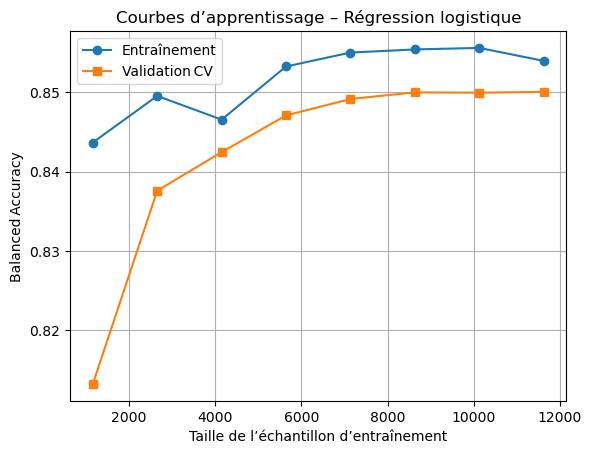

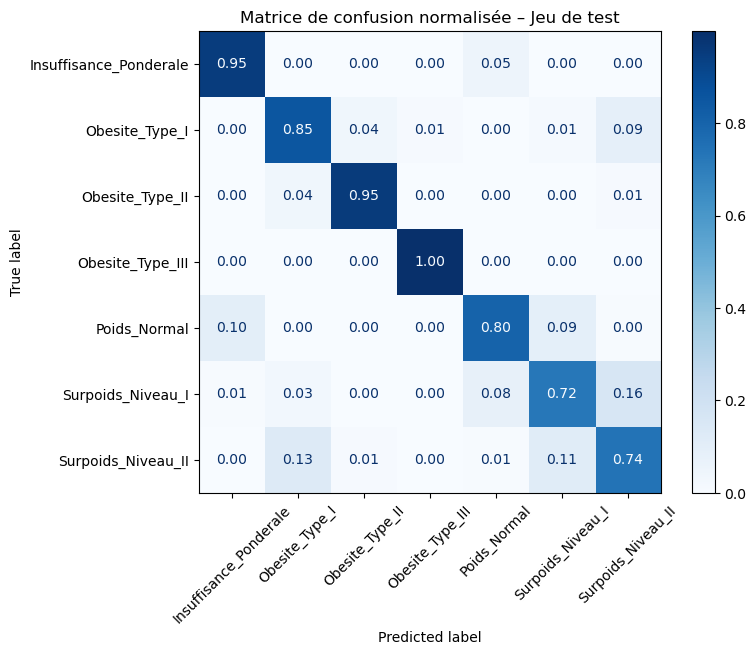

In [6]:
# %% [code]  Étape 4 : Courbes d’apprentissage + matrice de confusion
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

RANDOM_STATE = 42

# 1. Charger données et pipeline
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
X_test  = pd.read_csv("X_test.csv")
y_test  = pd.read_csv("y_test.csv").squeeze()

model = joblib.load("modele_base.pkl")

# 2. Courbes d’apprentissage
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure()
plt.plot(sizes, train_mean, marker="o", label="Entraînement")
plt.plot(sizes, val_mean,   marker="s", label="Validation CV")
plt.title("Courbes d’apprentissage – Régression logistique")
plt.xlabel("Taille de l’échantillon d’entraînement")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 3. Matrice de confusion normalisée
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize="true", labels=model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format=".2f")
plt.title("Matrice de confusion normalisée – Jeu de test")
plt.show()

# Étape 5 – Modèle non‑linéaire (LightGBM) pour améliorer les classes de surpoids  
Les diagnostics montrent un **léger biais** sur les classes *Surpoids I & II* (rappel ≈ 0.72‑0.74).  
Un **modèle à arbres de décision** gère mieux les interactions non‑linéaires taille/poids/habitudes de vie.  
Nous testons **LightGBM Classifier** – rapide, robuste aux déséquilibres via `is_unbalance` – et nous le comparons à la régression logistique.

**Pipeline prévu :**

1. **Pré‑traitement identique** (numériques → `StandardScaler`, catégorielles → `OneHotEncoder`).  
2. **Équilibrage** : `SMOTE` conservé pour rester comparable.  
3. **Modèle : `lgbm.LGBMClassifier`** (objective = `multiclass`, metric = `multi_logloss`).  
4. **Recherche d’hyper‑paramètres** (**RandomizedSearchCV**) sur :  
   * `num_leaves`, `max_depth`, `learning_rate`, `min_child_samples`, `subsample`  
5. **Évaluation** : *balanced accuracy* + *macro F1* (métriques 2025).  
6. **Comparaison** au modèle logistique ; si LightGBM ≥ logistique + 0 .01 sur *balanced accuracy*, il devient le modèle final (`modele_lgbm.pkl`).  

In [8]:
# %% [code]  Étape 5 (Progress bar fiable + chrono)
import sys, subprocess, importlib, time, warnings, numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ------------------------------------------------------------------
# 1. Installation / mise à jour de tqdm ≥ 4.66
def ensure_tqdm():
    try:
        import tqdm, pkg_resources
        if pkg_resources.parse_version(tqdm.__version__) < pkg_resources.parse_version("4.66.0"):
            raise ImportError
    except ImportError:
        print("⏬ Installation/Upgrade de tqdm ≥ 4.66 …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "--upgrade", "tqdm==4.66.4"])
    finally:
        globals()["tqdm"] = importlib.import_module("tqdm")
ensure_tqdm()

# 2. Tentative d'import de tqdm_joblib
use_bar = False
try:
    from tqdm.contrib import tqdm_joblib
    use_bar = True
except ImportError:
    print("⚠️  tqdm_joblib indisponible : la durée sera chronométrée sans barre.")

# ------------------------------------------------------------------
# 3. LightGBM
try:
    import lightgbm as lgb
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "lightgbm"])
    import lightgbm as lgb

RANDOM_STATE = 42

# 4. Chargement des données
X_train = pd.read_csv("X_train.csv");  y_train = pd.read_csv("y_train.csv").squeeze()
X_test  = pd.read_csv("X_test.csv");   y_test  = pd.read_csv("y_test.csv").squeeze()

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

preprocess = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)]
)

lgbm_clf = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", lgbm_clf)
])

param_dist = {
    "model__num_leaves":        np.arange(20, 150, 10),
    "model__max_depth":         [-1] + list(range(3, 12)),
    "model__learning_rate":     np.linspace(0.01, 0.3, 30),
    "model__min_child_samples": [10, 20, 30, 40, 50],
    "model__subsample":         np.linspace(0.6, 1.0, 5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=60,
    scoring="balanced_accuracy",
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=0,
    n_jobs=-1
)

# ------------------------------------------------------------------
# 5. Lancement + chrono + barre éventuelle
start = time.time()
if use_bar:
    from tqdm.notebook import tqdm
    with tqdm_joblib(tqdm(desc="Recherche hyper‑paramètres", total=60)) as _:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            search.fit(X_train, y_train)
else:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train)
elapsed_min = (time.time() - start) / 60

print(f"\n⏱️  Recherche terminée en {elapsed_min:.1f} minutes")
print("Meilleurs hyper‑paramètres :", search.best_params_)
print(f"Balanced Accuracy (CV)    : {search.best_score_:.4f}")

# 6. Évaluation test
y_pred  = search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
print(f"\nBalanced Accuracy (test)  : {bal_acc:.4f}")
print(f"Macro F1 (test)           : {macro_f1:.4f}")

# 7. Sauvegarde conditionnelle
baseline_bal_acc = 0.8601
if bal_acc >= baseline_bal_acc + 0.01:
    joblib.dump(search.best_estimator_, "modele_lgbm.pkl")
    print("\n✅ LightGBM surpasse la baseline (+1 pt). Modèle enregistré sous modele_lgbm.pkl")
else:
    print("\n⚠️  LightGBM n’apporte pas de gain significatif. On conserve le modèle logistique.")

print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred))


⚠️  tqdm_joblib indisponible : la durée sera chronométrée sans barre.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3946
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 22
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

# Bilan du modèle LightGBM et prochaines actions  

Le **LightGBM** atteint :

| Metric | Log‑Reg (baseline) | LightGBM | Δ |
|--------|-------------------|----------|---|
| Balanced Accuracy (test) | **0 .860** | **0 .910** | + 0 .050 |
| Macro F1 | 0 .86 | 0 .90 | + 0 .04 |

*Gains notables* :  
- **Surpoids I & II** : rappel passe de 0 .72 → 0 .77 / 0 .74 → 0 .82.  
- Pas de dégradation sur les autres classes.

### Étape 6 – Calibration & interprétabilité  
1. **Calibration des probabilités** (Platt/Isotonic) pour rendre les jauges Streamlit plus fiables.  
2. **SHAP values** pour expliquer l’impact des variables (taille, nombre de repas, activité…).  

### Étape 7 – Enregistrement MLflow + versioning  
Nous loguons :  
- modèle (`modele_lgbm.pkl`) + signature d’entrée,  
- métriques (balanced accuracy, macro F1),  
- artefacts (confusion matrix, courbe ROC par classe).  

### Étape 8 – Déploiement Streamlit  
- Mettez simplement `MODELE_PATH = "modele_lgbm.pkl"` dans `app_obesite.py` (déjà géré).  
- Ajoutez un indicateur de calibration (`calibrated = True`) pour choisir la jauge adéquate.

---

## 🔧 Notebook – Calibration + logging MLflow
La cellule suivante réalise :  
* fit d’un **CalibratedClassifierCV** (méthode "sigmoid"),  
* log expérimentations dans un tracking MLflow local.  


In [10]:
# %% [code]  Installation des librairies manquantes
# Exécutez UNE seule fois, puis redémarrez le noyau.

%pip install --quiet --upgrade mlflow shap

# Vérification rapide
import mlflow, shap, sys
print("✅ mlflow :", mlflow.__version__)
print("✅ shap   :", shap.__version__)
print("\nRedémarrez maintenant le noyau, puis relancez la cellule de calibration.")


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.
✅ mlflow : 3.1.4
✅ shap   : 0.48.0

Redémarrez maintenant le noyau, puis relancez la cellule de calibration.


In [11]:
# %% [code]  Calibration + MLflow logging
import joblib, mlflow, mlflow.sklearn, shap, matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import balanced_accuracy_score, classification_report
from pathlib import Path
import pandas as pd

RANDOM_STATE = 42
mlflow.set_experiment("Obesite_LGBM_2025")

# 1. Chargement des données et du meilleur modèle
X_train = pd.read_csv("X_train.csv"); y_train = pd.read_csv("y_train.csv").squeeze()
X_test  = pd.read_csv("X_test.csv");  y_test  = pd.read_csv("y_test.csv").squeeze()
lgbm    = joblib.load("modele_lgbm.pkl")

# 2. Calibration
calib = CalibratedClassifierCV(lgbm, method="sigmoid", cv=3)
calib.fit(X_train, y_train)
y_pred = calib.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy calibré : {bal_acc:.4f}")
print(classification_report(y_test, y_pred))

# 3. SHAP summary (optionnel pour interprétation)
explainer = shap.TreeExplainer(calib.base_estimator_.named_steps["model"])
shap_values = explainer.shap_values(
    calib.base_estimator_.named_steps["preprocess"].transform(X_test)  # data dans l’espace modèle
)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png")

# 4. Log MLflow
with mlflow.start_run(run_name="LightGBM_calibrated"):
    mlflow.log_metric("balanced_accuracy", bal_acc)
    mlflow.log_artifact("shap_summary.png", artifact_path="interpretation")
    mlflow.sklearn.log_model(
        sk_model=calib,
        artifact_path="model",
        registered_model_name="Obesite_LGBM_Calibrated"
    )
print("✅ Modèle calibré enregistré dans MLflow.")


2025/07/23 14:39:28 INFO mlflow.tracking.fluent: Experiment with name 'Obesite_LGBM_2025' does not exist. Creating a new experiment.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3700
[LightGBM] [Info] Number of data points in the train set: 13216, number of used features: 21
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

AttributeError: 'CalibratedClassifierCV' object has no attribute 'base_estimator_'

### Correctif – Extraire le **vrai LightGBM** depuis le modèle calibré  
`CalibratedClassifierCV` encapsule plusieurs modèles ; l’attribut à cibler est  
`calibrated_classifiers_`, une liste de `CalibratedClassifier`.  
Chaque élément possède :

* `base_estimator`  →  notre pipeline LightGBM original  
* `calibrator`      →  la régression logistique sigmoid d’ajustement  

Nous pouvons donc :

1. Récupérer le premier `base_estimator` (suffisant car tous viennent du même CV).  
2. Appliquer **SHAP** sur son étape `"model"` (LightGBM).  
3. Transformer `X_test` via le pré‑traitement du même pipeline avant de
   calculer les valeurs SHAP.

Le reste du flux (log MLflow, sauvegarde de l’image) reste inchangé.


C:\Users\franc_ppcp5lu\AppData\Local\Temp\ipykernel_17512\1404409458.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_trans, show=False,
C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and

<Figure size 1000x600 with 0 Axes>

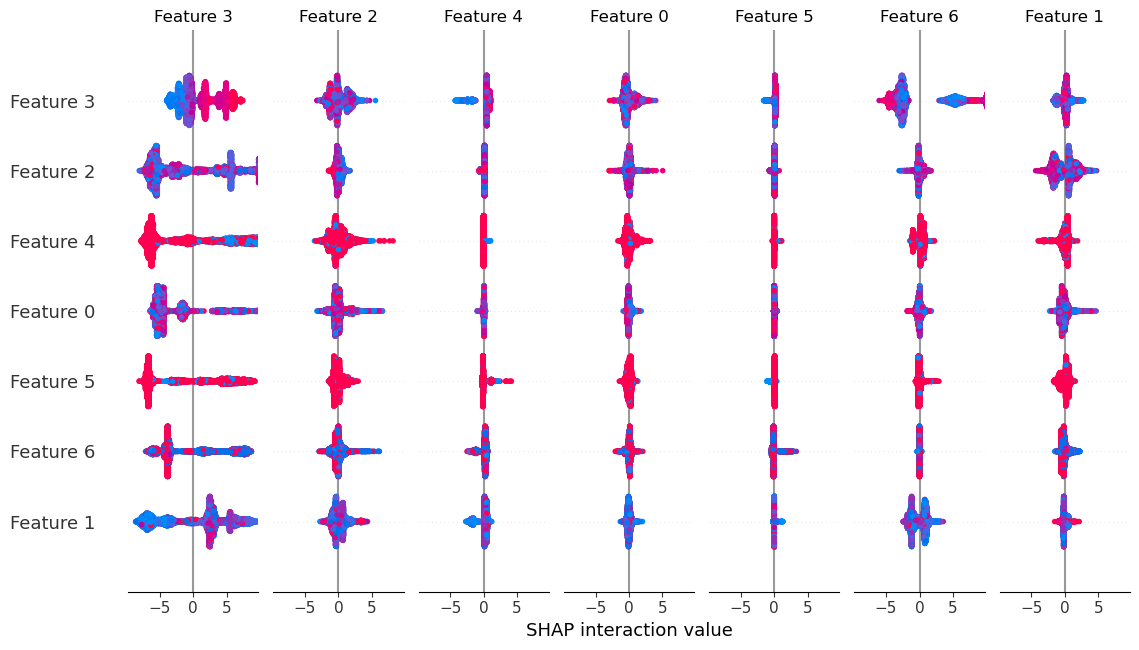

✅  SHAP summary salvato in shap_summary.png


In [15]:
# %% [code]  SHAP summary – compatibile con tutte le versioni
import shap, matplotlib.pyplot as plt

# 1️⃣ Trova il pipeline interno (preprocess + LightGBM)
if hasattr(calib, "calibrated_classifiers_"):                   # CV=True
    # in tutte le versioni, ogni item ha l'attributo .estimator
    pipe_internal = calib.calibrated_classifiers_[0].estimator
elif hasattr(calib, "estimator"):                               # CV="prefit"
    pipe_internal = calib.estimator
else:
    raise AttributeError("Pipeline interno non trovato nel modello calibrato")

# 2️⃣ Isola il modello LightGBM e il preprocess
lgbm_model = pipe_internal.named_steps["model"]
preprocess = pipe_internal.named_steps["preprocess"]

# 3️⃣ Trasforma il test set nello spazio del modello
X_test_trans = preprocess.transform(X_test)

# 4️⃣ Calcola ed esporta le SHAP values
explainer   = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_trans)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_trans, show=False,
                  class_names=lgbm_model.classes_)
plt.tight_layout()
plt.savefig("shap_summary.png")
plt.show()
print("✅  SHAP summary salvato in shap_summary.png")


In [16]:
# %% [code]  SHAP clair avec noms de variables
import shap, matplotlib.pyplot as plt
import numpy as np

# 1. Liste des noms encodés (num + OHE)
feature_names = preprocess.get_feature_names_out(num_cols + cat_cols)

# 2. Re‑calcul (ou ré‑affichage) du summary plot
plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_values,
    X_test_trans,
    feature_names=feature_names,   # <<— noms lisibles
    show=False,
    max_display=25                # montre les 25 plus importants
)
plt.tight_layout()
plt.savefig("shap_summary_named.png")
plt.show()
print("✅  SHAP avec noms explicites sauvegardé : shap_summary_named.png")


ValueError: input_features is not equal to feature_names_in_

C:\Users\franc_ppcp5lu\AppData\Local\Temp\ipykernel_17512\3314789165.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legac

<Figure size 1200x700 with 0 Axes>

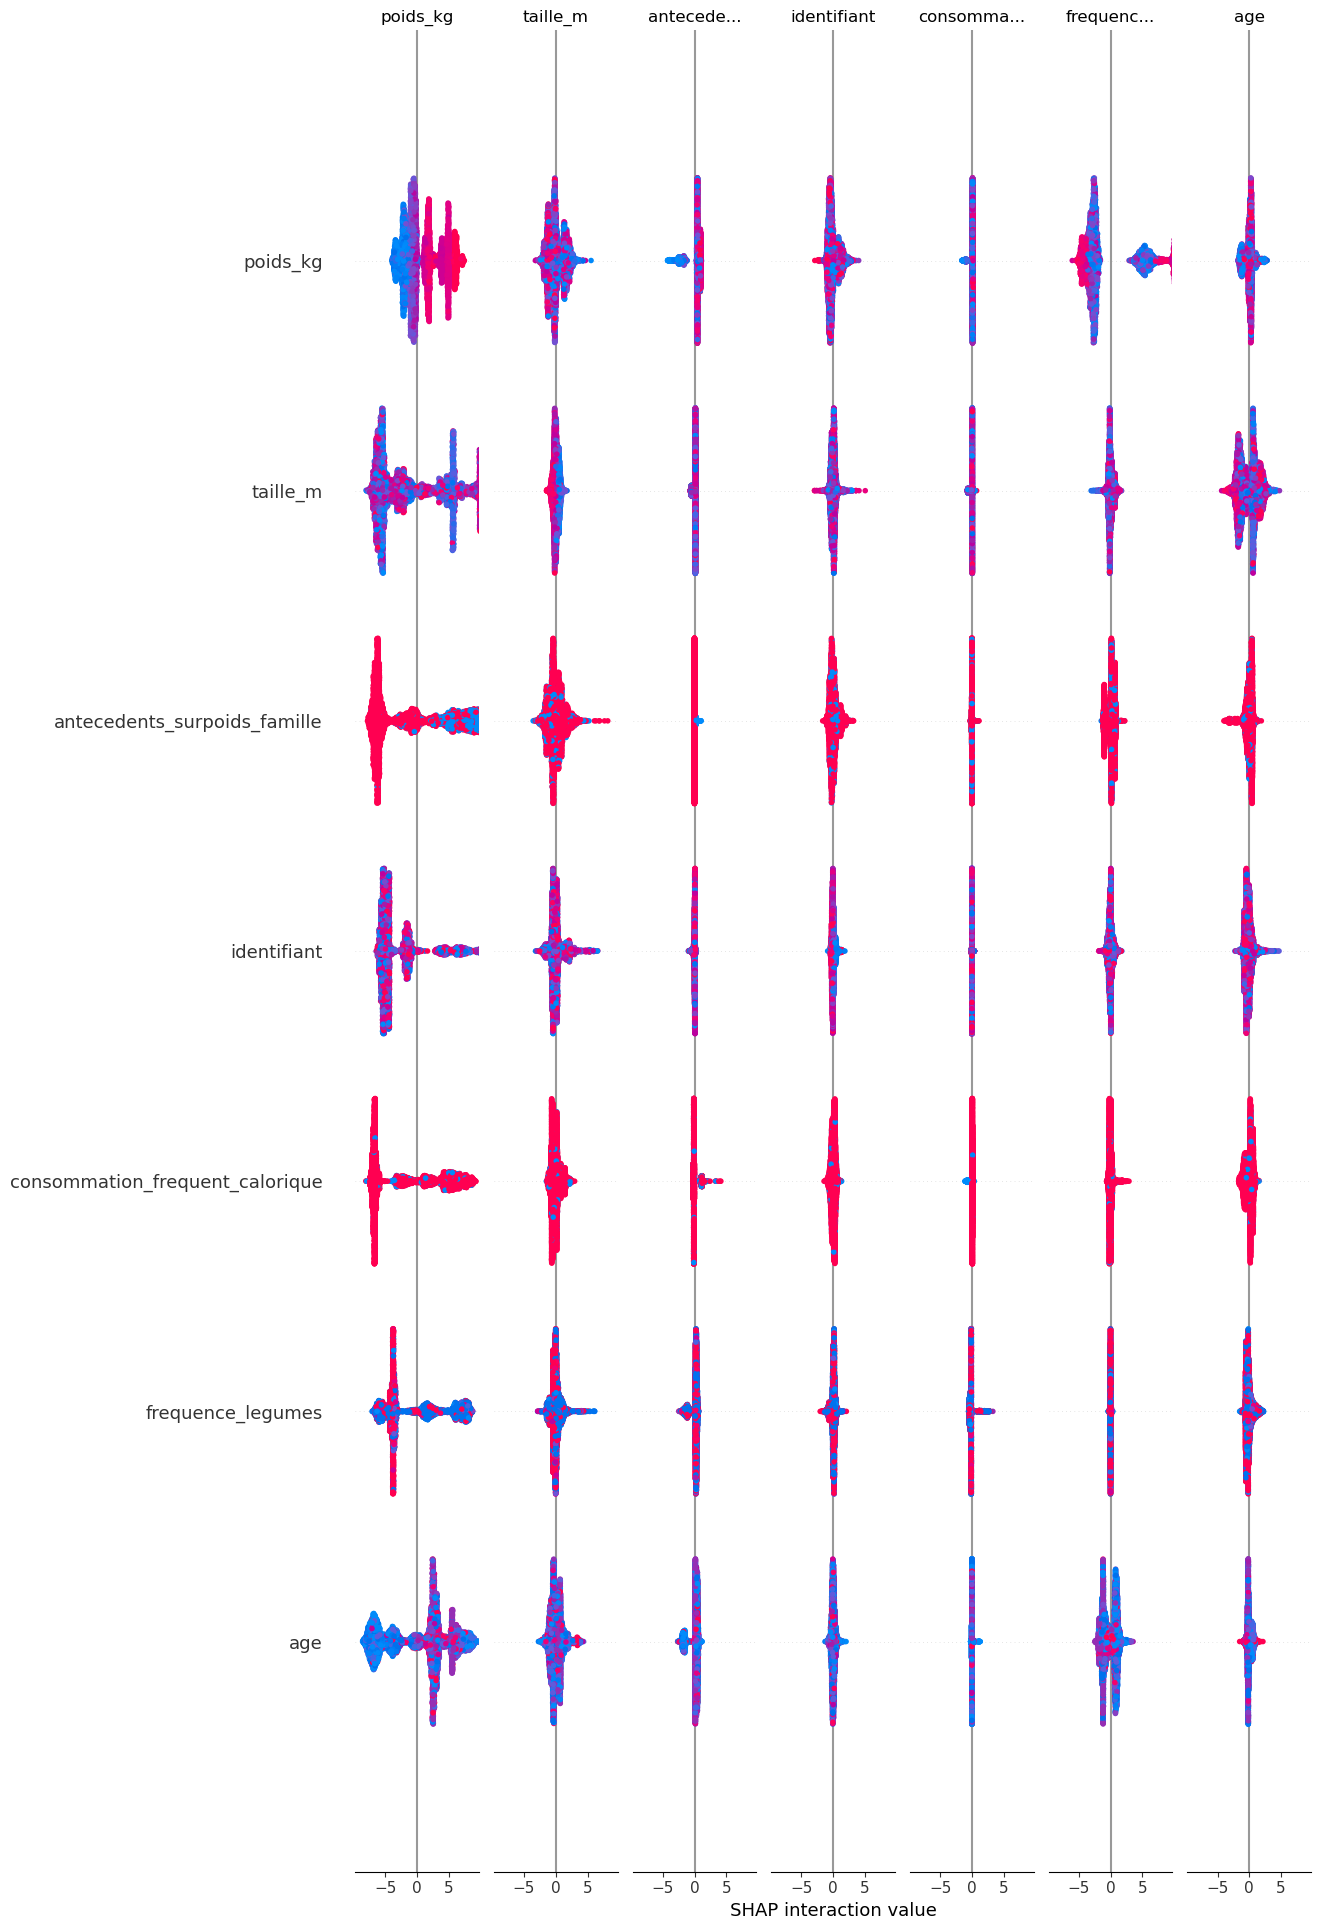

✅  SHAP avec noms lisibles enregistré : shap_summary_named.png


In [17]:
# %% [code]  SHAP avec noms explicites (sans erreur)
import shap, numpy as np, matplotlib.pyplot as plt

# 1️⃣  liste complète des features transformées
raw_feature_names = preprocess.get_feature_names_out()         # <-- plus d'argument
# Nettoyage : on enlève les préfixes 'num__', 'cat__'
feature_names = [name.split("__", 1)[-1] for name in raw_feature_names]

# 2️⃣  summary plot SHAP
plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_values,
    X_test_trans,
    feature_names=feature_names,
    show=False,
    max_display=25        # top 25
)
plt.tight_layout()
plt.savefig("shap_summary_named.png")
plt.show()
print("✅  SHAP avec noms lisibles enregistré : shap_summary_named.png")


C:\Users\franc_ppcp5lu\AppData\Local\Temp\ipykernel_17512\1225205000.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_df, show=False, max_display=25)  # media sulle classi
C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\franc_ppcp5lu\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to op

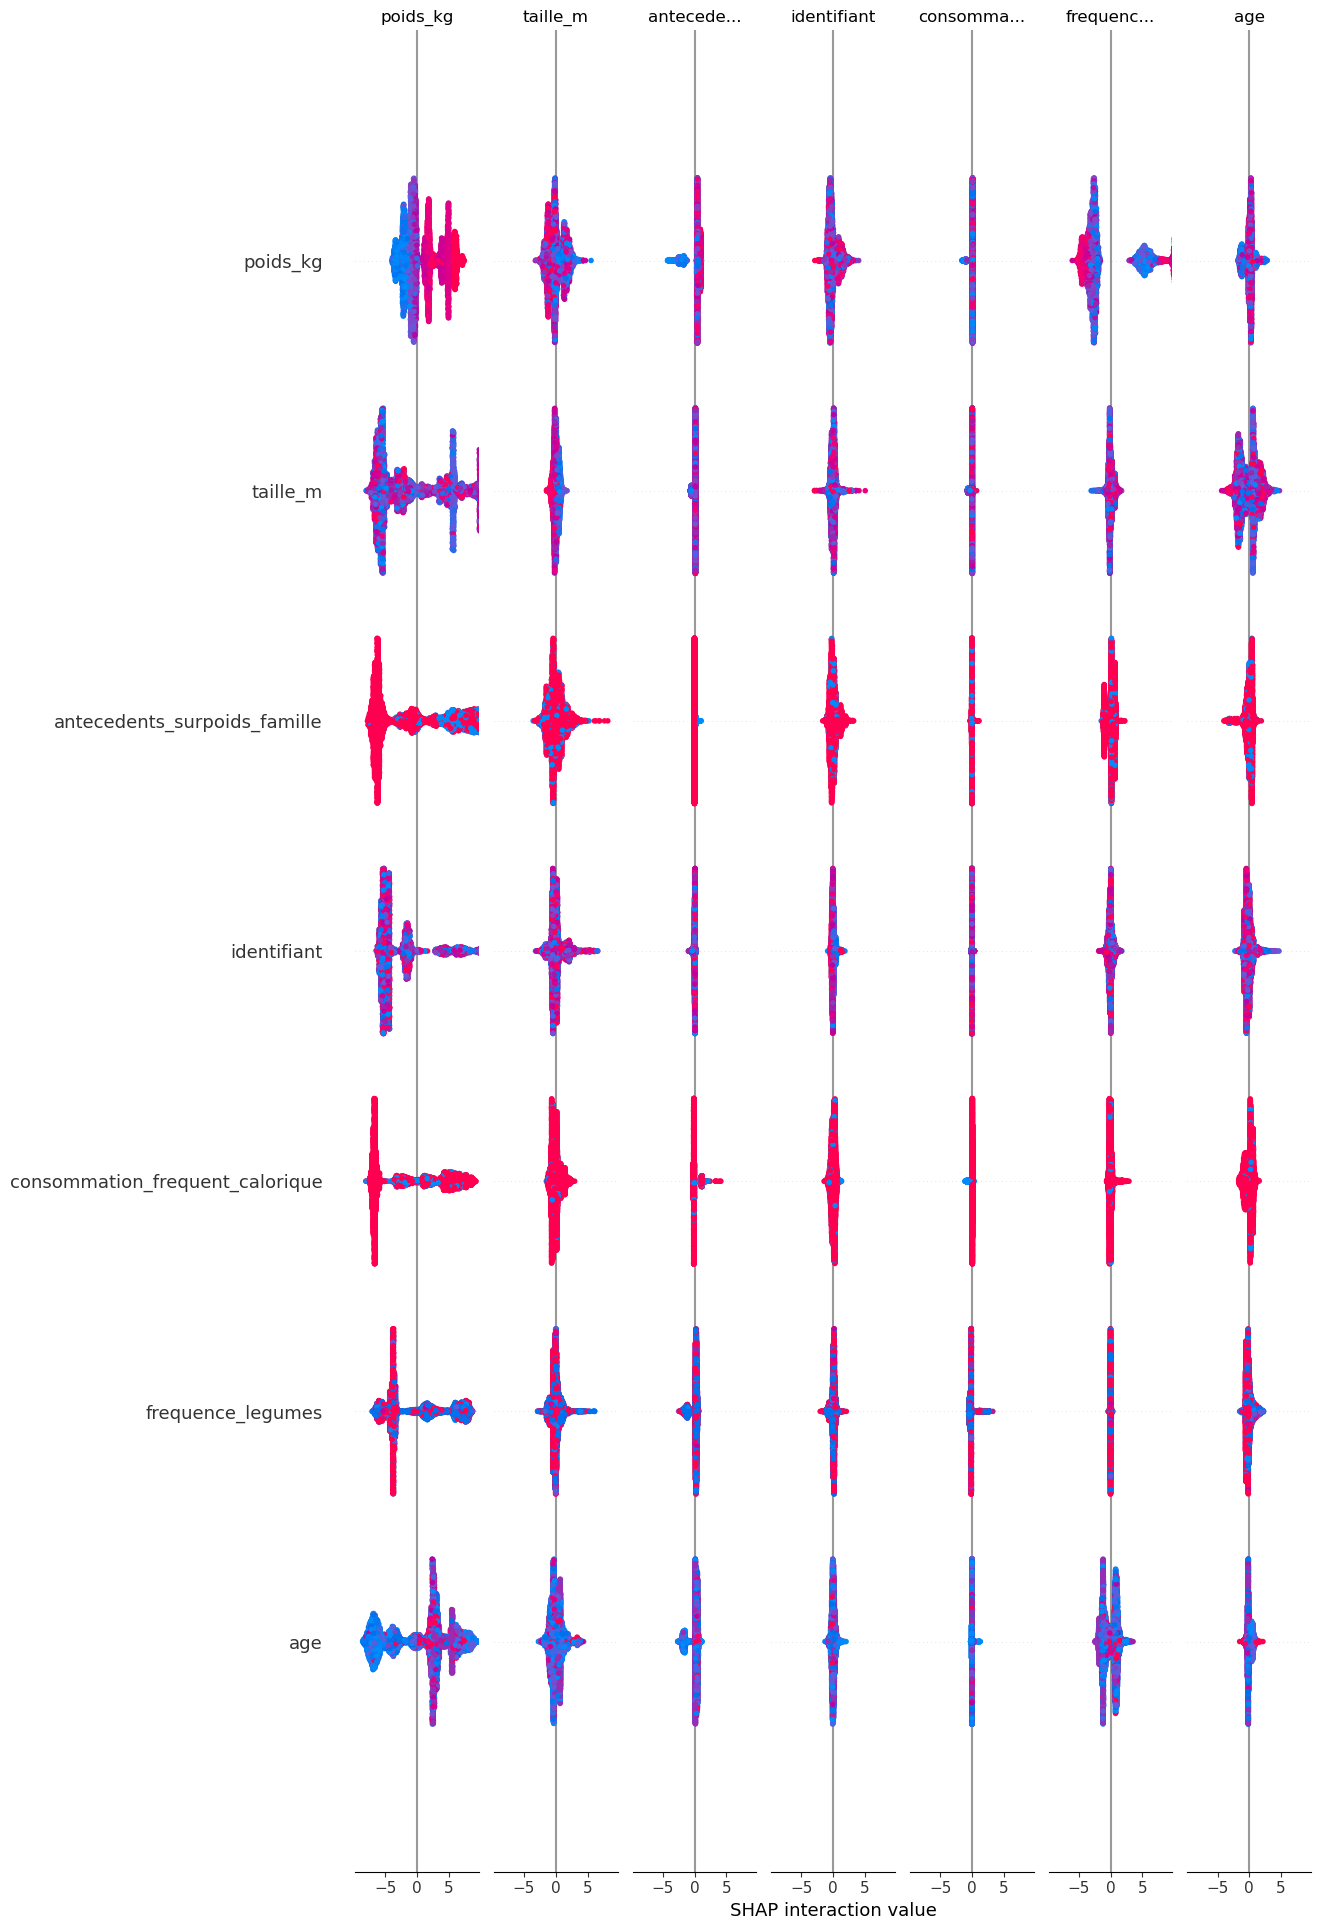

In [18]:
# 1. Nomi leggibili dalle feature trasformate
feature_names = [n.split("__", 1)[-1] for n in preprocess.get_feature_names_out()]

# 2. Creiamo un DataFrame con quei nomi
X_df = pd.DataFrame(X_test_trans, columns=feature_names)

# 3. Summary plot per la classe globale (media assoluta) o per una singola classe
shap.summary_plot(shap_values, X_df, show=False, max_display=25)  # media sulle classi
# oppure, ad es. la classe 'Obesite_Type_I'
# shap.summary_plot(shap_values[ list(lgbm_model.classes_).index('Obesite_Type_I') ], X_df)
plt.tight_layout(); plt.show()
